In [29]:
from __future__ import print_function
import ugradio
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import scipy.signal

In [30]:
units = {"time": "($\mu$s)",
         "frequency": "(MHz)",
         "temperature": "(K)",
         "velocity": "($km \cdot s^{-1}$)",
         "voltage": "($\mu$V)",
         "voltage spectra": "($\mu V \cdot \mu s$)",
         "power spectra": "($\mu V^{2} \cdot \mu s^{2}$)"
        }

time = {"Local": ugradio.timing.local_time(),
        "UTC": ugradio.timing.utc(), # current UTC as a string
        "UTC seconds": ugradio.timing.unix_time(),
        "Julian": ugradio.timing.julian_date(), # current Julian day and time,
        "LST": ugradio.timing.lst() # current LST at NCH
       }

In [31]:
HI_freq = 1420.4

def scaled(data, volt_range): 
    """
    Rescales sampler data.

    Parameters:
    data (array) : data to be rescaled
    volt_range (double) : volt range input parameter

    Returns:
    output (array) : rescaled data
    """
    scaled = (data * volt_range) / np.power(2, 15) / 2
    return scaled

def shift(array):
    return np.fft.fftshift(array)

def plot_histogram(title, data, nbins = 25):
    '''
    Plots a histogram with a fitted Gaussian overlayed on top of it. 
    
    Parameters: 
    title (string): title of the plot
    data (array): data to be plotted in histogram
    nbins (int): number of bins that the histogram will parse data into
    
    '''
    histogram = plt.figure(figsize = [8, 5])
    data = sorted(data)
    fit = stats.norm.pdf(data, np.mean(data), np.std(data))
    plt.hist(data, bins = nbins, normed = True, color = 'c')
    plt.plot(data, fit, 'k')
    plt.title(title)
    plt.xlabel("Voltage " + units["voltage"])
    plt.ylabel("Number of Samples (Normed)")
    
def load(filename, nblocks):
    '''
    Parameters:
    filename (string): address of the file being loaded
    nblocks (int): number of blocks in sample
    
    Returns:
    complex_array (array): complex array where each element is A + iB
    real_split (array): array of real components of the complex array
    imag_split (array): array
    '''
    signal = scaled(np.load(filename), 0.05)
    split = np.split(signal, 2)
    real, imaginary = split[0], split[1]
    real_split, imag_split = np.split(real, nblocks), np.split(imaginary, nblocks)
    complex_array = []
    for i in range(nblocks):
        complex_array.append(real_split[i] + 1j * imag_split[i])
    return complex_array, real_split, imag_split

In [32]:
def save_picture(fig, title):
    fig.savefig("Pictures\\" + title + '.png')

In [33]:
# Code I stole from other people

def power_spectra(signal, v_samp, nsamples):
    """
    Returns the power spectrum of a given signal as a function of frequency

    Parameters:
    signal (array) : signal data
    v_samp (double) : sampling frequency
    nsamples (int) : number of samples per block

    Returns:
    power (array) : power spectrum
    freqs (array) : frequencies
    """
    
    nblocks = len(signal)
    power = []
    for i in range(0, nblocks):
        ft = np.fft.fft(signal[i])
        power.append(np.abs(ft) ** 2)
    dt = 1 / v_samp
    freqs = np.fft.fftfreq(nsamples, d = dt)
    return -freqs, power

### Section 6.2: Your Measurement

In [34]:
folder = "Lab2week1/"
v_samp = 62.5
divisor = 1
volt_range = "50mV"

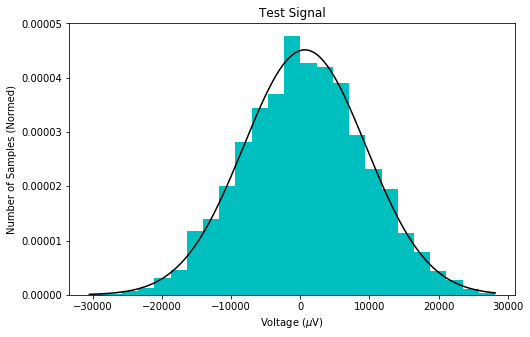

In [35]:
test = np.load(folder + "dsb.npy")
plot_histogram("Test Signal", test)

#### Long Integration to Get the Line Shape (Measurement)

In [36]:
upper, upper_real, upper_imag = [], [], []
for i in range(10):
    output, real, imag = load("newupper" + str(i) + ".npy", 99)
    upper += output
    upper_real += real
    upper_imag += imag

In [37]:
lower, lower_real, lower_imag = [], [], []
for i in range(10):
    output, real, imag = load("newlower" + str(i) + ".npy", 99)
    lower += output
    lower_real += real
    lower_imag += imag

In [38]:
upper, upper_real, upper_imag = np.asarray(upper), np.asarray(upper_real), np.asarray(upper_imag)
lower, lower_real, lower_imag = np.asarray(lower), np.asarray(lower_real), np.asarray(lower_imag)

#### Intensity Calibration (Measurement)

In [39]:
sky, sky_real, sky_imag =  load(folder + "sky.npy", 10)
people, people_real, people_imag = load(folder + "threepeople.npy", 10)

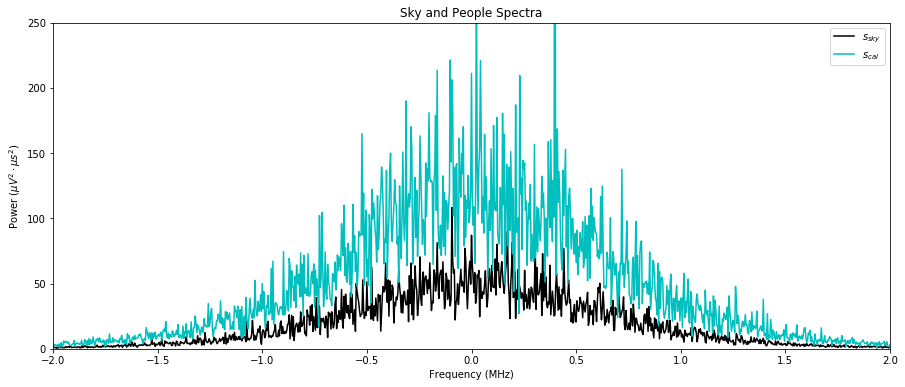

In [40]:
plt.figure(figsize = [15, 6])

sky_freq, sky_pwr = power_spectra(sky, 62.5, 16000)
ave_sky = np.mean(sky_pwr, axis = 0)

people_freq, people_pwr = power_spectra(people, 62.5, 16000)
ave_people = np.mean(people_pwr, axis = 0)

plt.plot(shift(sky_freq), shift(ave_sky), color = "k", label = "$s_{sky}$")
plt.plot(shift(people_freq), shift(ave_people), color = "c", label = "$s_{cal}$")
plt.title("Sky and People Spectra")
plt.xlabel("Frequency " + units["frequency"])
plt.ylabel("Power " + units["power spectra"])
plt.xlim(-2, 2)
plt.ylim(0, 250)
plt.legend()
plt.show()

### Section 7.1: Take a Suitable Average/Median

#### Taking the Average

In [41]:
upper_freqs, upperspec = power_spectra(upper, 62.5/5., 10000)
lower_freqs, lowerspec = power_spectra(lower, 62.5/5., 10000)

upper_freqs, upperspec = shift(upper_freqs), shift(upperspec)
lower_freqs, lowerspec = shift(lower_freqs), shift(lowerspec)

In [42]:
mean_upperspec = np.mean(upperspec, axis = 0)
mean_lowerspec = np.mean(lowerspec, axis = 0)

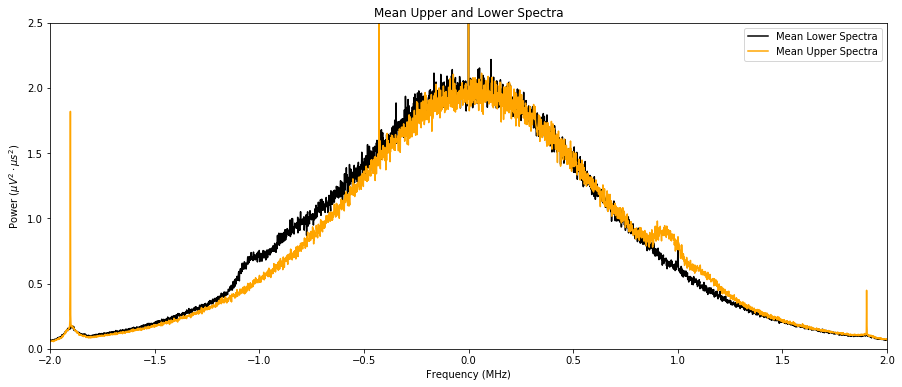

In [43]:
fig1 = plt.figure(figsize = [15, 6])
plt.plot(lower_freqs, mean_lowerspec, color = "k", label = "Mean Lower Spectra")
plt.plot(upper_freqs, mean_upperspec, color = "orange", label = "Mean Upper Spectra")
plt.title("Mean Upper and Lower Spectra")
plt.xlabel("Frequency " + units['frequency'])
plt.ylabel("Power " + units['power spectra'])
plt.xlim(-2, 2)
plt.ylim(0, 2.5)
plt.legend()
plt.show()
save_picture(fig1, "MeanSpectra")

#### Taking the Median

In [44]:
median_upperspec = np.median(upperspec, axis = 0)
median_lowerspec = np.median(lowerspec, axis = 0)

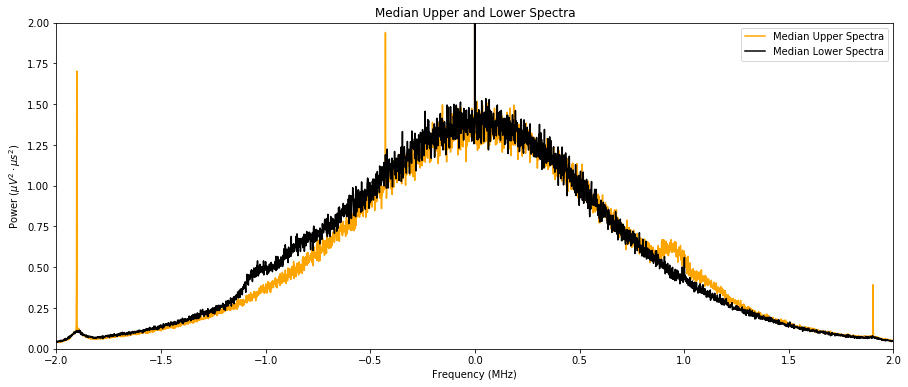

In [45]:
plt.figure(figsize = [15, 6])
plt.plot((upper_freqs), median_upperspec, color = "orange", label = "Median Upper Spectra")
plt.plot((lower_freqs), median_lowerspec, color = "k", label = "Median Lower Spectra")
plt.title("Median Upper and Lower Spectra")
plt.xlabel("Frequency " + units['frequency'])
plt.ylabel("Power " + units['power spectra'])
plt.xlim(-2, 2)
plt.ylim(0, 2)
plt.legend()
plt.show()

### Section 7.2: Get the Line Shape

In [47]:
def son_soff(upperspec, lowerspec):
    """
    Creates online spectrum and offline spectrum from the upper spectra and lower spectra
    
    Parameters:
    upperspec (list): upper spectrum
    lowersepec (list): lower spectrum
    
    Returns:
    s_on (array): online spectrum
    s_off (array): offline spectrum
    """
    left_upper, right_upper = np.split(upperspec, 2)
    left_lower, right_lower = np.split(lowerspec, 2)
    s_off = list(right_upper) + list(left_lower)
    s_on = list(left_upper) + list(right_lower)
    return np.asarray(s_on), np.asarray(shift(s_off))
    

s_on, s_off = son_soff(mean_upperspec, mean_lowerspec)
s_line = s_on/s_off

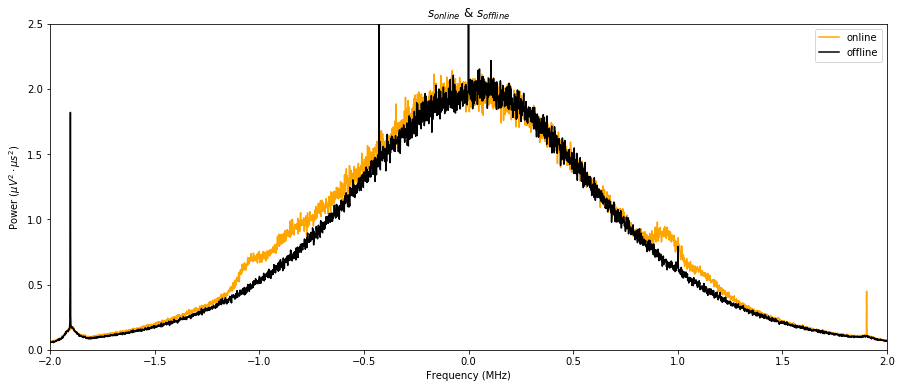

In [48]:
fig2 = plt.figure(figsize = [15, 6])
plt.plot(lower_freqs, s_on, color = "orange", label = "online")
plt.plot(lower_freqs, s_off, color = "k", label = "offline")
plt.title("$s_{online}$ & $s_{offline}$")
plt.xlabel("Frequency " + units["frequency"])
plt.ylabel("Power " + units["power spectra"])
plt.xlim(-2, 2)
plt.ylim(0, 2.5)
plt.legend()
plt.show()
save_picture(fig2, "sonoff")

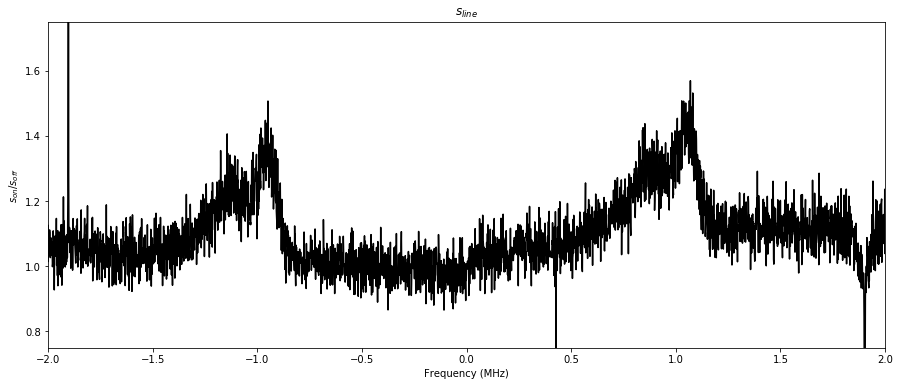

In [49]:
# I know this plot is wrong but I'm happy I got anything at all tbh
fig1 =plt.figure(figsize = [15, 6])
plt.plot(-lower_freqs, s_line, color = "k")
plt.title("$s_{line}$")
plt.xlabel("Frequency " + units["frequency"])
plt.ylabel("$s_{on}/s_{off}$")
plt.xlim(-2, 2)
plt.ylim(0.75, 1.75)
plt.show()
save_picture(fig1, "sline")

### 7.3 Get the Line Intensity

In [50]:
# T_sky is 3K, so we consider this negligible.

T_cal = 300 
s_cal = ave_people
s_cold = ave_sky
gain = T_cal / np.sum(s_cal - s_cold) * np.sum(s_cold) # calculate gain
print(gain)
T_line = s_line * gain # calculate T_line, our calibrated spectrum

194.96510307042584


### 7.4 Plotting Intensity vs. Frequency -- and Velocity

#### Plot Calibrated Spectrum

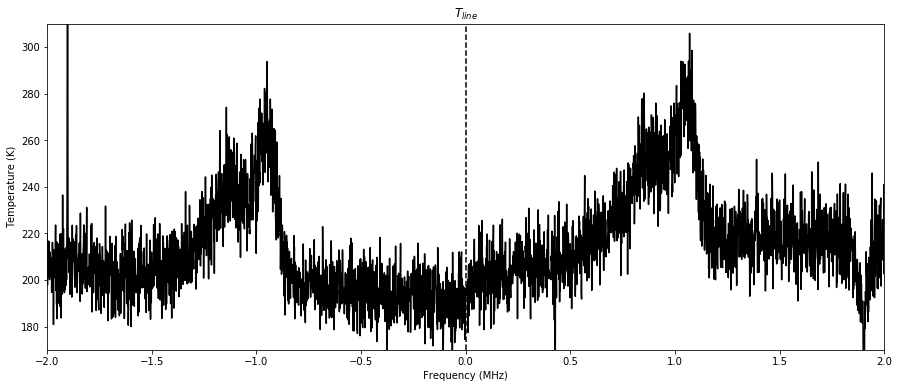

In [51]:
fig1 = plt.figure(figsize = [15, 6])
v_samp = 62.5/5.
T_freqs = np.fft.fftfreq(10000, 1/v_samp)
plt.plot(shift(T_freqs), T_line, color = "k")
plt.title("$T_{line}$")
plt.xlabel("Frequency " + units["frequency"])
plt.ylabel("Temperature " + units["temperature"])
plt.axvline(0, color = "k", linestyle = "--")
plt.xlim(-2, 2)
plt.ylim(170, 310)
plt.show()
save_picture(fig1, "tline")

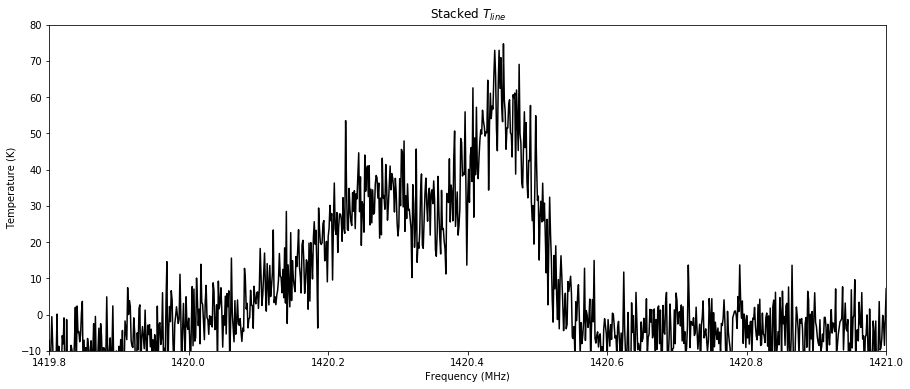

In [61]:
left_side, right_side = np.split(T_line, 2) 
new_line = (np.asarray(left_side[3400:]) + np.asarray(right_side[:1600]))/2
poly = np.polyfit(doppler_velocity, new_line, 1)
T_fit = np.polyval(poly, doppler_velocity)
corrected_dopvel = doppler_velocity
flat_T_stacked = new_line - T_fit + 1

fig2 = plt.figure(figsize = [15, 6])
plt.plot(T_freqs[:1600] + 189.4 + 1230, flat_T_stacked, color = "k")
plt.title("Stacked $T_{line}$")
plt.xlabel("Frequency " + units["frequency"])
plt.ylabel("Temperature " + units["temperature"])
plt.xlim(1419.8, 1421)
plt.ylim(-10, 80)
plt.show()
save_picture(fig2, "stackedtline")

#### Plot Against Doppler Velocity

In [26]:
T_stacked = new_line
T_stacked_freq = T_freqs[:1600] + 189.4 + 1230

In [27]:
nu = 1420.4
delta_nu = T_stacked_freq - nu
c = 3e5
doppler_velocity = (delta_nu / nu) * c

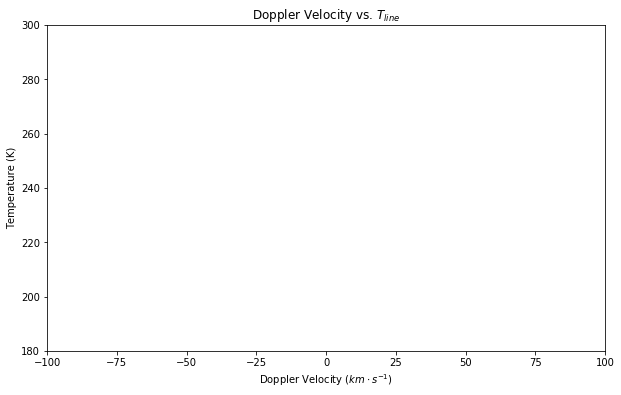

In [28]:
plt.figure(figsize = [10, 6])
plt.plot(doppler_velocity, T_stacked, color = "k")
plt.title("Doppler Velocity vs. $T_{line}$")
plt.xlabel("Doppler Velocity " + units["velocity"])
plt.ylabel("Temperature " + units["temperature"])
plt.xlim(-100, 100)
plt.ylim(180, 300)
plt.show()

### 7.5 Choose a Reference Frame

In [27]:
lst = np.load("dopplerlst.npy")
julian_date = np.load("juliandate.npy")
ra, dec, jd = lst, 37.873199, julian_date
correction = ugradio.doppler.get_projected_velocity(ra, dec, jd)/1e3

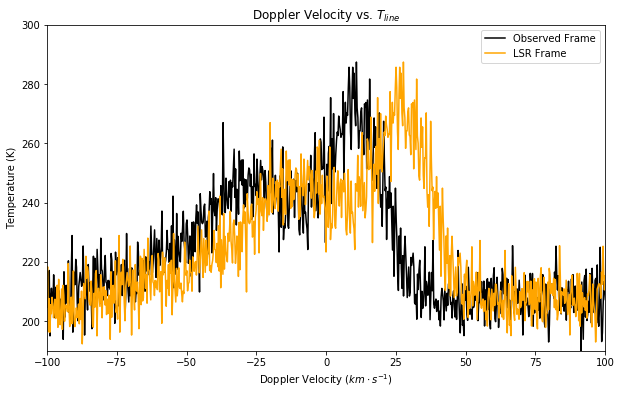

In [28]:
plt.figure(figsize = [10, 6])
plt.plot(doppler_velocity, T_stacked, color = "k", label = "Observed Frame")
plt.plot(doppler_velocity - correction, T_stacked, color = 'orange', label = "LSR Frame")
plt.title("Doppler Velocity vs. $T_{line}$")
plt.xlabel("Doppler Velocity " + units["velocity"])
plt.ylabel("Temperature " + units["temperature"])
plt.xlim(-100, 100)
plt.ylim(190, 300)
plt.legend()
plt.show()

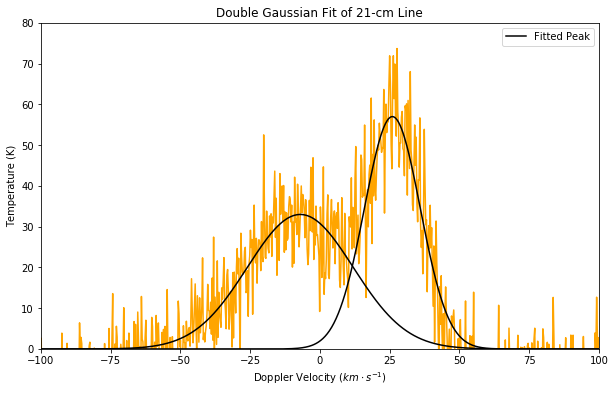

In [30]:
fig6 = plt.figure(figsize = [10, 6])
x_p = np.linspace(-211, 210, 1600)
p3 = ugradio.gauss.gaussfit(corrected_dopvel, flat_T_stacked)
peak1 = ugradio.gauss.gaussval(corrected_dopvel, 33, -1, 19)
peak2 = ugradio.gauss.gaussval(corrected_dopvel, 57, -1, 10)
plt.title("Double Gaussian Fit of 21-cm Line")
plt.xlabel("Doppler Velocity " + units["velocity"])
plt.ylabel("Temperature " + units["temperature"])
plt.plot(corrected_dopvel, flat_T_stacked, color = "orange")
plt.plot(corrected_dopvel - 6, peak1, color = "k", label = "Fitted Peak")
plt.plot(corrected_dopvel + 27, peak2, color = "k")
plt.legend()
plt.xlim(-100, 100)
plt.ylim(0, 80)
save_picture(fig6, "gaussianfit")

### Section 9: Propagation Velocity Measurements

In [31]:
coax = {"Frequency": 3,
        "Open": [5.5, 10.5, 15.5, 20.5, 25.5, 30.5, 35.5, 40.5, 45.5, 50.5],
        "Shut": [3, 8, 13, 18, 23, 28, 33, 38, 43, 48]}

sig_75 = {"Frequency": 7.5,
          "Open": [8, 12.4, 16.4],
          "Shut": [9, 13.1, 17.5]}

sig_775 = {"Frequency": 7.75,
           "Open": [10.1, 14, 17.5],
           "Shut": [8.5, 12.2, 15.8]}

sig_8 = {"Frequency": 8,
         "Open": [8.5, 11.6, 15],
         "Shut": [8, 11.4, 14.6, 18]}

sig_825 = {"Frequency": 8.25,
           "Open": [9.9, 13, 15.9],
           "Shut": [10.3, 13.2, 16.2]}

sig_85 = {"Frequency": 8.5,
          "Open": [8.4, 11.1, 14, 16.8],
          "Shut": [9.3, 12, 14.8, 17.7]}

sig_9 = {"Frequency": 9,
         "Open": [8, 10.7, 13, 15, 17.9],
         "Shut": [10, 12.7, 15.2, 17.6]}

In [34]:
# http://macao.communications.museum/eng/Exhibition/secondfloor/moreinfo/2_11_0_StandingWave.html

def prop_velocity(frequency, wavelength):
    return frequency * 1e9 * wavelength / 100000
    
waveguide_signals = [sig_75, sig_775, sig_8, sig_825, sig_85, sig_9]

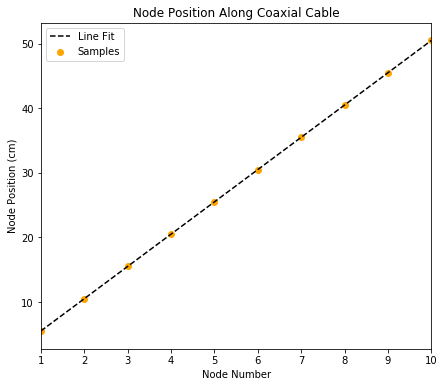

In [35]:
fig6 = plt.figure(figsize = [7, 6])
m = np.linspace(1, 10, 10)
x_m = coax["Open"]
polyfit = np.polyfit(m, x_m, 1)
y_values = np.polyval(polyfit, m)
plt.plot(m, y_values, color = "k", linestyle = "--", label = "Line Fit")
plt.scatter(m, x_m, color = "orange", label = "Samples")
plt.ylabel("Node Position (cm)")
plt.xlabel("Node Number")
plt.title("Node Position Along Coaxial Cable")
plt.xlim(1, 10)
plt.legend()
plt.show()
save_picture(fig6, "nodeposition")

#### Coax Cable

##### First Method

In [36]:
def average_slotted_wavelength(signal, slot):
    """
    Calculates the (averaged) slotted wavelength and its error.
    
    Parameters:
    signal (dictionary): contains the frequency (key: "Frequency"), the locations for null points for an open waveguide
        (key: "Open") and shut waveguide (key: "Shut")
    slot (string): indicates whether we are looking at the null positions of the "Open" or "Shut" waveguide.
    
    Returns:
    average_wavelength (int): the averaged slotted wavelength
    error (int): the uncertainty of average_wavelength
    """
    nulls = signal[slot]
    wavelen = [2*(nulls[x] - nulls[x - 1]) for x in range(1, len(nulls))]
    average_wavelength = np.mean(wavelen)
    error = np.mean(wavelen)/np.sqrt(len(nulls)-1)
    return average_wavelength, error

In [37]:
open_ave, open_err = average_slotted_wavelength(coax, "Open")
print("OPEN: ")
print("Average Slotted Wavelength = " + str(round(open_ave, 2)) + " cm +/- " + str(round(open_err, 2)))

OPEN: 
Average Slotted Wavelength = 10.0 cm +/- 3.33


In [38]:
shut_ave, shut_err = average_slotted_wavelength(coax, "Shut")
print("SHUT: ")
print("Average Slotted Wavelength = " + str(round(shut_ave, 2)) + " cm +/- " + str(round(shut_err, 2)))

SHUT: 
Average Slotted Wavelength = 10.0 cm +/- 3.33


##### Second Method

In [40]:
def slotted_wavelength(signal, slot):
    x_m = np.array(coax[slot])
    m = np.linspace(1, 10, 10)
    first_order, zero_order = np.polyfit(m, x_m, 1)
    return zero_order, round(np.mean( 2 * (x_m - zero_order) / m), 2)

for signal in waveguide_signals:
    A1, wavelength = slotted_wavelength(signal, "Open")
    propagation_velocity = prop_velocity(coax["Frequency"], wavelength)
    print("A = " + str(round(A1, 2)) + " cm and Slotted Wavelength = " + str(wavelength) + " cm")

    A2, wavelength = slotted_wavelength(signal, "Shut")
    propagation_velocity = prop_velocity(coax["Frequency"], wavelength)
    print("A = " + str(round(A2, 2)) + " cm and Slotted Wavelength = " + str(wavelength) + " cm")

A = 0.5 cm and Slotted Wavelength = 10.0 cm
A = -2.0 cm and Slotted Wavelength = 10.0 cm
A = 0.5 cm and Slotted Wavelength = 10.0 cm
A = -2.0 cm and Slotted Wavelength = 10.0 cm
A = 0.5 cm and Slotted Wavelength = 10.0 cm
A = -2.0 cm and Slotted Wavelength = 10.0 cm
A = 0.5 cm and Slotted Wavelength = 10.0 cm
A = -2.0 cm and Slotted Wavelength = 10.0 cm
A = 0.5 cm and Slotted Wavelength = 10.0 cm
A = -2.0 cm and Slotted Wavelength = 10.0 cm
A = 0.5 cm and Slotted Wavelength = 10.0 cm
A = -2.0 cm and Slotted Wavelength = 10.0 cm


#### Waveguide

In [44]:
def guide_wavelength(signal, slot):
    """
    Calculates guide wavelength of a signal inside a waveguide.
    
    Parameters:
    signal (array): the signal in waveguide
    slot (string): indicates if slow it "Shut" or "Open"
    
    Returns:
    guide_wavelength (array): guide wavelengths
    """
    
    x_g = np.array(signal[slot])
    g = np.linspace(1, len(x_g), len(x_g))
    first_order, zero_order = np.polyfit(g, x_g, 1)
    return 2 * (x_g - zero_order) / g
    
def calculate_a(signal, slot = "Open"):
    '''
    Function calculates the a-value using equation (6) in the lab write-up. 
    
    Parameters:
    signal (dictionary): contains the frequency (key: "Frequency"), the locations for null points for an open waveguide
        (key: "Open") and shut waveguide (key: "Shut")
    slot (string): indicates whether we are looking at the null positions of the "Open" or "Shut" waveguide.
    '''
    guidelen = round(np.mean(guide_wavelength(signal, slot)),2)
    freespace_len = 3e10 / ((1e9) * signal["Frequency"]) 
    a = freespace_len / (2 * (1 - (freespace_len/guidelen)**(2))**(1/2))
    
    print("\n Guide Wavelength = " + str(wavelength) + " cm")
    print("Propagation Velocity = " + str(signal["Frequency"] * 1e9 * guidelen / 100000) + " km/s")
    print("a = " + str(round(a,2)) + " cm")
    return a

In [45]:
open_a_values = []
for signal in waveguide_signals:
    a = calculate_a(signal, "Open")
    open_a_values.append(a)
print("\n Average a-value = " + str(round(np.mean(open_a_values), 2)) + " cm")


 Guide Wavelength = 10.0 cm
Propagation Velocity = 629250.0 km/s
a = 2.0 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 572725.0 km/s
a = 1.94 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 520800.0 km/s
a = 1.88 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 494175.0 km/s
a = 1.82 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 478550.0 km/s
a = 1.76 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 432900.0 km/s
a = 1.67 cm

 Average a-value = 1.84 cm


In [46]:
shut_a_values = []
for signal in waveguide_signals:
    a = calculate_a(signal, "Shut")
    shut_a_values.append(a)
print("\n Average a-value = " + str(round(np.mean(shut_a_values), 2)) + " cm")


 Guide Wavelength = 10.0 cm
Propagation Velocity = 638250.0 km/s
a = 2.0 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 565750.0 km/s
a = 1.94 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 531200.0 km/s
a = 1.88 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 486750.0 km/s
a = 1.82 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 476850.0 km/s
a = 1.76 cm

 Guide Wavelength = 10.0 cm
Propagation Velocity = 453600.0 km/s
a = 1.67 cm

 Average a-value = 1.84 cm


In [47]:
for signal in waveguide_signals:
    freq = signal["Frequency"]
    open_guide_wavelengths = guide_wavelength(signal, "Open")
    signal["Prop Vel (Open)"] = prop_velocity(freq, open_guide_wavelengths)
    shut_guide_wavelengths = guide_wavelength(signal, "Shut")
    signal["Prop Vel (Shut)"] = prop_velocity(freq, shut_guide_wavelengths)

In [48]:
def get_error_bar(data):
    """
    Calculates error bar of a set of data.
    
    Parameters:
    data (array): data you are calculating error for
    
    Returns:
    error bar (int): the error of your data
    """
    
    standard_deviation = np.std(data)
    return standard_deviation / np.sqrt(len(data))

In [49]:
open_frequencies = []
open_velocities = []
open_errorbars = []

for signal in waveguide_signals:
    freq = signal["Frequency"]
    velocity = signal["Prop Vel (Open)"]
    for v in range(len(velocity)):
        open_frequencies.append(freq)
        open_velocities.append(velocity[v])
    open_errorbars.append(get_error_bar(velocity))

In [50]:
shut_frequencies = []
shut_velocities = []
shut_errorbars = []

for signal in waveguide_signals:
    freq = signal["Frequency"]
    velocity = signal["Prop Vel (Shut)"]
    for v in range(len(velocity)):
        shut_frequencies.append(freq)
        shut_velocities.append(velocity[v])
    shut_errorbars.append(get_error_bar(velocity))

In [51]:
def plot_freq_vs_velocity(frequencies, velocities, errorbars, slot = ""):
    xfit = np.linspace(min(frequencies)-0.2, max(frequencies)+0.2, 100)
    poly = np.polyfit(frequencies, velocities, 2)
    yfit = np.polyval(poly, xfit)
    plt.plot(xfit, yfit, color = "k", linestyle = "--", label = slot + " Fit")
    frequency_points = [7.5, 7.75, 8, 8.25, 8.5, 9]
    velocity_points = np.polyval(poly, frequency_points)
    for i in range(len(frequency_points)):
        plt.errorbar(frequency_points[i], velocity_points[i], yerr=errorbars[i], color = "orange", fmt='--o')
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Velocity ($km\cdot s^{-1}$)")
    plt.title("Frequency vs. Propagation Velocity (" + slot + ")")

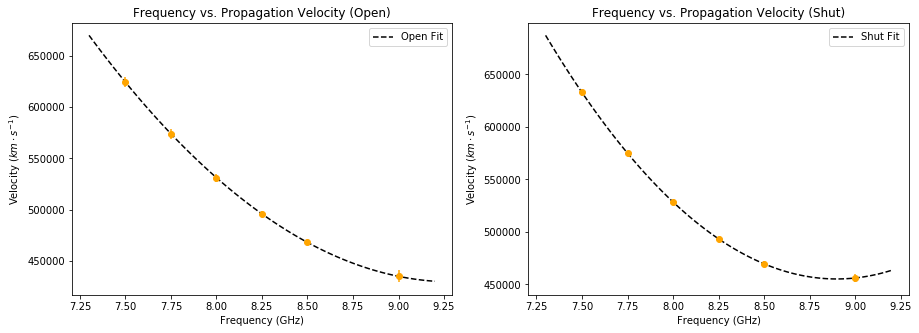

In [52]:
prop = plt.figure(figsize = [15, 5])
plt.subplot(1, 2, 1)
plot_freq_vs_velocity(open_frequencies, open_velocities, open_errorbars, "Open")
plt.legend()
plt.subplot(1, 2, 2)
plot_freq_vs_velocity(shut_frequencies, shut_velocities, shut_errorbars, "Shut")
plt.legend()
plt.show()
save_picture(prop, "propvelocity")